---

## Deep Learning Coding Project 3-4: Generative Adversarial Network

Before we start, please put your **Chinese** name and student ID in following format:

Name, 0000000000 // e.g.) 傅炜, 2021123123

YOUR ANSWER HERE

## Introduction

We will use Python 3, [NumPy](https://numpy.org/), and [PyTorch](https://pytorch.org/) packages for implementation. This notebook has been tested under the latest stable release version.

In this coding project, you will implement 4 generative models, i.e., energy-based model, flow-based model, variational auto-encoder, and generative adverserial network, to generate MNIST images.

**We will implement a generative adversarial network, specifically a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/abs/1511.06434) (DCGAN), in this notebook.**

In some cells and files you will see code blocks that look like this:

```Python
##############################################################################
#                  TODO: You need to complete the code here                  #
##############################################################################
raise NotImplementedError()
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################
```

You should replace `raise NotImplementedError()` with your own implementation based on the context, such as:

```Python
##############################################################################
#                  TODO: You need to complete the code here                  #
##############################################################################
y = w * x + b
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

```

When completing the notebook, please adhere to the following rules:

+ Do not write or modify any code outside of code blocks
+ Do not add or delete any cells from the notebook.
+ Run all cells before submission. We will not re-run the entire codebook during grading.

**Finally, avoid plagiarism! Any student who violates academic integrity will be seriously dealt with and receive an F for the course.**

### Task

In this problem, you need to do class-conditioned generation on MNIST images by training a DCGAN. You should

1. **Complete the code of the generator $G : (z, y) → x$ and the discriminator $D : (x, y) → [0, 1]$.**

Both of them should be **fully convolutional networks (FCNs)** except for linear projection heads. For FCN, please refer to [this paper](https://arxiv.org/pdf/1411.4038.pdf) for details.

2. **Implement the training procedure.**

3. **Include necessary tricks applied in [DCGAN](https://arxiv.org/pdf/1511.06434.pdf).**

We present an example of generated images using DCGAN in the following cell.

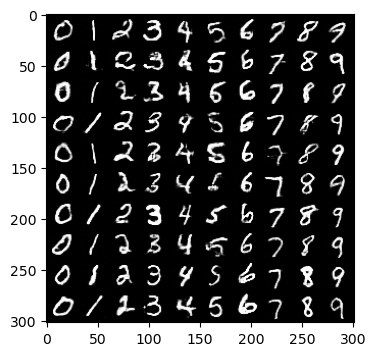

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 6, 4
plt.imshow(mpimg.imread('./gan/sample.png'))

### Submission

You need to submit your code (this notebook), your trained **generator** (named `./gan/gan_best.pth`), your generated images, and your report:

+ **Code**

Remember to run all the cells before submission. Remain your tuned hyperparameters unchanged.

+ **Generator**

In this notebook, we do not include codes to find the best model like the previous ones. You need to visualize generated images, manually select the best one, and save it as `./gan/gan_best.pth`. **Please do not submit any other checkpoints except for `./gan/gan_best.pth`!**

+ **Generated Images**

Please generate 100 images for each class (1000 in total), save it in `./gan/generated/`, and organize them as the following structure:

```
CodingProject3
├── ...
├── gan
│   ├── gan_best.pth
│   ├── generated
│       └── 0
│           ├── 0_00.png
│           ├── ...
│           ├── 0_99.png
│       └── 1
│           ├── 1_00.png
│           ├── ...
│           ├── 1_99.png
│       └── ...
│       └── 9
│           ├── 9_00.png
│           ├── ...
│           ├── 9_99.png
```

Specifially, you should name the $j$-th generated image of class $i$ as `{i}_{j}.png`, and save it into folder `./gan/generated/{i}/`. Check the `make_dataset` method of Generator for details.

+ **Report**

Please include the conditioned generation results (i.e., generated images in a $10\times 10$ array as above), the FID score, the standard deviation for each class, and other relevant statistics in your
report. Note that you only need to write a single report for this coding project.

### Grading

We will evaluate your model by **computing the [FID score](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance)**, as what we do for conditioned VAE.

In addition, the standard deviation of your generated images within
each class must **exceed a certain threshold**. Suppose the generated samples for
each class are of size (number of samples, 28, 28) with pixel values range
from 0 to 1, the standard deviation is given by `torch.std(samples, dim=0).mean()`. The thresholds for different digits are listed in the following table:

| Digit | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 8    | 9    |
|-------|------|------|------|------|------|------|------|------|------|------|
| Threshold   | 0.17 | 0.08 | 0.17 | 0.15 | 0.14 | 0.16 | 0.15 | 0.13 | 0.15 | 0.13 |

### Tips

+ Monitoring the generated images in the training process. The quality of the samples helps judge the generator's ability to learn a diverse representation of the input data distribution.

+ See [here](https://developers.google.com/machine-learning/gan/problems) for tricks to prevent mode collapse.

+ Make sure your runs fine with the evaluation file in this notebook.

## Set Up Code

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


If you use Colab in this coding project, please uncomment the code, fill the `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` and run the following cells to mount your Google drive. Then, the notebook can find the required file (i.e., utils.py). If you run the notebook locally, you can skip the following cells.

In [22]:
# from google.colab import drive
# drive.mount('/content/drive')

In [23]:
# import os

# # TODO: Fill in the Google Drive path where you uploaded the assignment
# # Example: If you create a 2022SP folder and put all the files under CP1 folder, then '2022SP/CP1'
# # GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2022SP/CP1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None 
# GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
# print(os.listdir(GOOGLE_DRIVE_PATH))

In [24]:
# import sys
# sys.path.append(GOOGLE_DRIVE_PATH)

In [25]:
from utils import hello
hello()

Good luck!


Finally, please run the following cell to import some base classes for implementation (no matter whether you use colab).

In [26]:
from collections import deque
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm

import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from utils import save_model, load_model, train_set

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

## Generator

Please implement your own generator module, which should be a fully convolutional network with linear projection heads.

In [29]:
class resnetblock(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, padding=1,stride = 1):
        super(resnetblock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        # self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        self.activation = nn.LeakyReLU(0.2)
    def forward(self, x):
        residual = x
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        # if x.shape[1] != residual.shape[1]:
        #     residual = self.conv3(residual)
        x = x + residual
        return x

In [30]:
class newGenerator(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.label_size = label_size = 10
        self.latent_size = latent_size
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        self.total_size = label_size + latent_size
        self.sz1 = 2
        self.projection = nn.Sequential(
            nn.Linear(self.total_size, 256 * self.sz1 * self.sz1),
            nn.ReLU()
        )
        self.up_sample = nn.Upsample(scale_factor = 2)
        self.startup1 = resnetblock(256,256)
        self.startup2 = resnetblock(256,256)
        self.conv1 = nn.Sequential(
            resnetblock(256,256,kernel_size = 5),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            resnetblock(256,128,kernel_size = 4),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            resnetblock(128,128,kernel_size = 4, stride = 2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            resnetblock(128,64,kernel_size = 4),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            resnetblock(64,64,kernel_size = 6),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv6 = nn.ConvTranspose2d(64,1,kernel_size = 1)
        self.final_activation = nn.LeakyReLU(0.2)
        # 首先将z和label拼接在一起，然后对拼接完成的向量做projection，然后接到ConvTranspose上
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

    def forward(self, z, label):
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        '''
        主要的结构是：首先进行projection，然后用conv2d和up进行upsampling，中间的conv2d被resnet替换
        注意这里我没法运行所以形状是没有调的，需要自己调一下
        upsample
        resnet(256,256)
        resnet(256,256)
        upsample
        resnet(256,128)
        upsample
        resnet(128,128)
        upsample
        resnet(128,64)
        upsample
        resnet(64,64)
        leakyrelu
        tanh
        这是目前的格式，可能需要调整
        '''
        preprocess_label = torch.zeros([label.shape[0],10]).to(label.device)
        label = torch.scatter(preprocess_label,1,label.unsqueeze(1),value = 1).to(label.device)
        total_label = torch.cat((z,label),dim = 1)
        #total label shape
        total_label = self.projection(total_label)
        print(total_label.shape)
        total_label = total_label.reshape(-1,256,self.sz1,self.sz1)
        total_label = self.up_sample(total_label)
        total_label = self.startup1(total_label)
        total_label = self.startup2(total_label)
        total_label = self.up_sample(total_label)
        x2 = self.conv1(total_label)
        x2 = self.up_sample(x2)
        x3 = self.conv2(x2)
        x3 = self.up_sample(x3)
        x4 = self.conv3(x3)
        x4 = self.up_sample(x4)
        x5 = self.conv4(x4)
        x5 = self.up_sample(x5)
        x6 = self.conv5(x5)
        x6 = self.up_sample(x6)
        x7 = self.conv6(x6)
        x7 = self.final_activation(x7)
        x8 = torch.tanh(x7)
        # print(x8.shape)
        # x = x8[:,:,1:29,1:29]
        return x8
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

    @torch.no_grad()
    def sample_images(self, label, save=True, save_dir='./gan'):
        self.eval()
        n_samples = label.shape[0]
        samples = self(torch.randn(
            n_samples, self.latent_size).to(label.device), label)
        imgs = samples.view(n_samples, 1, 28, 28)
        if save:
            os.makedirs(save_dir, exist_ok=True)
            torchvision.utils.save_image(imgs, os.path.join(
                save_dir, 'sample.png'), nrow=int(np.sqrt(n_samples)))
        return imgs
    
    @torch.no_grad()
    def make_dataset(self, n_samples_per_class=10, save=True, save_dir='./gan/generated/'):
        self.eval()
        device = next(self.parameters()).device
        for i in range(self.label_size):
            label = i * torch.ones(n_samples_per_class, dtype=torch.long, device=device)
            samples = self(torch.randn(
                n_samples_per_class, self.latent_size).to(device), label)
            imgs = samples.view(n_samples_per_class, 1, 28, 28)
            print(f"Standard deviation of number {i}: {torch.std(imgs, dim=0).mean().item()}")
            if save:
                os.makedirs(os.path.join(save_dir, str(i)), exist_ok=True)
                for j in range(n_samples_per_class):
                    torchvision.utils.save_image(imgs[j], os.path.join(save_dir, str(i), "{}_{:>03d}.png".format(i, j)))

In [31]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.label_size = label_size = 10
        self.latent_size = latent_size
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        self.total_size = label_size + latent_size
        self.sz1 = 2
        self.projection = nn.Sequential(
            nn.Linear(self.total_size, 256 * self.sz1 * self.sz1),
            nn.ReLU()
        )
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(256,256,kernel_size = 5),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(256,128,kernel_size = 4),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(128,128,kernel_size = 4, stride = 2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(128,64,kernel_size = 4),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.ConvTranspose2d(64,64,kernel_size = 6),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv6 = nn.ConvTranspose2d(64,1,kernel_size = 1)
        # 首先将z和label拼接在一起，然后对拼接完成的向量做projection，然后接到ConvTranspose上
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

    def forward(self, z, label):
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        preprocess_label = torch.zeros([label.shape[0],10]).to(label.device)
        label = torch.scatter(preprocess_label,1,label.unsqueeze(1),value = 1).to(label.device)
        total_label = torch.cat((z,label),dim = 1)
        total_label = self.projection(total_label)
        # print(total_label.shape)
        total_label = total_label.reshape(-1,256,self.sz1,self.sz1)
        #size:256*2*2
        x2 = self.conv1(total_label)
        #size:256*6*6
        x3 = self.conv2(x2)
        #size:128*9*9
        x4 = self.conv3(x3)
        #size:128*20*20
        x5 = self.conv4(x4)
        #size:64*23*23
        x6 = self.conv5(x5)
        #size:64*28*28
        x7 = self.conv6(x6)
        #size:1*28*28
        x8 = torch.tanh(x7)
        # print(x8.shape)
        # x = x8[:,:,1:29,1:29]
        return x8
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

    @torch.no_grad()
    def sample_images(self, label, save=True, save_dir='./gan'):
        self.eval()
        n_samples = label.shape[0]
        samples = self(torch.randn(
            n_samples, self.latent_size).to(label.device), label)
        imgs = samples.view(n_samples, 1, 28, 28)
        if save:
            os.makedirs(save_dir, exist_ok=True)
            torchvision.utils.save_image(imgs, os.path.join(
                save_dir, 'sample.png'), nrow=int(np.sqrt(n_samples)))
        return imgs
    
    @torch.no_grad()
    def make_dataset(self, n_samples_per_class=10, save=True, save_dir='./gan/generated/'):
        self.eval()
        device = next(self.parameters()).device
        for i in range(self.label_size):
            label = i * torch.ones(n_samples_per_class, dtype=torch.long, device=device)
            samples = self(torch.randn(
                n_samples_per_class, self.latent_size).to(device), label)
            imgs = samples.view(n_samples_per_class, 1, 28, 28)
            print(f"Standard deviation of number {i}: {torch.std(imgs, dim=0).mean().item()}")
            if save:
                os.makedirs(os.path.join(save_dir, str(i)), exist_ok=True)
                for j in range(n_samples_per_class):
                    torchvision.utils.save_image(imgs[j], os.path.join(save_dir, str(i), "{}_{:>03d}.png".format(i, j)))

## Discriminator

Please implement your own discriminator module, which should also be a fully convolutional network with linear projection heads.

**Hint**: Pay attention to the shape of your output and the shape of label.

In [ ]:
'''
这里我觉得不需要改 我看到的论文里面使用的也是conv2d 如果需要可以加深网络
'''
class newDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_size = label_size = 10
        
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size = 4, stride = 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,32,kernel_size = 3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        self.final_linear = nn.Linear(32*11*11,11)
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

    def forward(self, img, label):
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        x = img.view(-1,1,28,28)
        # print(x.shape)
        x1 = self.conv1(x)
        # print(x1.shape)
        x2 = self.conv2(x1)
        # x2 = x2.reshape(img[0],-1)
        # print(x2.shape)
        # print(x2)
        batch_size = x.shape[0]
        x2 = x2.view(batch_size, -1)
        # print(x2.shape)
        x3 = self.final_linear(x2)
        return x3
        #x is the scalar need to apply discriminator

        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

In [32]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_size = label_size = 10
        
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size = 4, stride = 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,32,kernel_size = 3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        self.final_linear = nn.Linear(32*11*11,11)
        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

    def forward(self, img, label):
        ##############################################################################
        #                  TODO: You need to complete the code here                  #
        ##############################################################################
        # YOUR CODE HERE
        x = img.view(-1,1,28,28)
        # print(x.shape)
        x1 = self.conv1(x)
        # print(x1.shape)
        x2 = self.conv2(x1)
        # x2 = x2.reshape(img[0],-1)
        # print(x2.shape)
        # print(x2)
        batch_size = x.shape[0]
        x2 = x2.view(batch_size, -1)
        # print(x2.shape)
        x3 = self.final_linear(x2)
        return x3
        #x is the scalar need to apply discriminator

        ##############################################################################
        #                              END OF YOUR CODE                              #
        ##############################################################################

## Training

We have implemented the skeleton of train function. Please complete the missing loss computation part.

In [33]:
def train(n_epochs, generator, discriminator, train_loader, optimizer_g, optimizer_d, device=torch.device('cuda'), save_interval=10):
    generator.to(device)
    discriminator.to(device)

    for epoch in range(n_epochs):
        train_g_loss = train_d_loss = 0
        std_loss_total = acc_first_total = acc_second_total = total_acc_total = acc_g_total = 0
        n_batches = 0
        pbar = tqdm(total=len(train_loader.dataset))
        print(train_loader.dataset)
        for i, (x, y) in enumerate(train_loader):
            # compute loss
            n_batches += x.shape[0]
            x = x.to(device)
            y = y.to(device)
            ##############################################################################
            #                  TODO: You need to complete the code here                  #
            ##############################################################################
            # YOUR CODE HERE
            #discriminator
            optimizer_d.zero_grad()
            optimizer_g.zero_grad()
            discriminator.train()
            real_image = discriminator(x,y)
            dloss_first = F.cross_entropy(real_image,y.long())  # Convert y to long data type
            z = torch.randn([y.shape[0],generator.latent_size]).to(device)
            gen_images = generator(z,y)
            # the real label of the image is y, differende between y and label is the loss
            # create a random label almost same for each scalar
            output = discriminator(gen_images,y)
            # print(f'output_shape{output.shape}')
            ones = torch.ones(output.shape[0])*10
            ones = ones.to(torch.long)
            # ones = ones.to(device)
            # to torch.long?
            eleven= (F.one_hot(ones,num_classes=11)*0.9).to(device)
            # print(f'eleven_shape{eleven.shape}')
            # print(eleven.shape)
            acc_first = ((real_image.argmax(dim=1)==y).to(torch.float).mean()).item()
            acc_second = ((output.argmax(dim=1)==10).to(torch.float).mean()).item()
            total_acc = (acc_first + acc_second) / 2
            second = F.cross_entropy(output,eleven) #one-side label smoothing
            # print(second.shape)
            # print(second)
            dloss_second = second
            d_loss = dloss_first + dloss_second
            d_loss.backward()
            optimizer_d.step()
            #generator 
            optimizer_d.zero_grad()
            optimizer_g.zero_grad()
            discriminator.eval()
            z = torch.randn([y.shape[0],generator.latent_size]).to(device)
            gen_image = []
            gen_images = generator(z,y)
            ##############################################################################
            #naive implement for 方差损失
            zs = []
            for i in range(10):
                zs.append(torch.randn([y.shape[0],generator.latent_size]).to(device))
            for i in range(10):
                gen_image.append(generator(zs[i],y))
            # gen_image_avg = torch.stack(gen_image).mean(dim = 0)
            gen_image_std = torch.stack(gen_image).std(dim = 0)
            #gen_image_std has size 1*28*28
            #sum all element in gen_image_std
            std_loss = gen_image_std.sum()
            ##############################################################################
            output = discriminator(gen_images,y)
            coeff = 40000
            g_loss = F.cross_entropy(output,y) - std_loss / coeff
            acc_g = ((output.argmax(dim=1)==y).to(torch.float).mean()).item()
            # print(output[1])
            # print(y)
            g_loss.backward()
            optimizer_g.step()  
            ##############################################################################
            #                              END OF YOUR CODE                              #
            ##############################################################################

            train_g_loss += g_loss.sum().item()
            train_d_loss += d_loss.sum().item()
            std_loss_total += std_loss/coeff
            acc_first_total += acc_first
            acc_second_total += acc_second
            total_acc_total += total_acc
            acc_g_total += acc_g
            pbar.update(x.size(0))
            pbar.set_description('Train Epoch {}, Generator Loss: {:.6f}, std_loss:{:.6f}, Discriminator Loss: {:.6f}, acc_first:{:.6f}, acc_second:{:.6f}, acc_descriminator:{:.6f}, acc_generator:{:.6f}'.format(
                epoch + 1, train_g_loss / n_batches, std_loss_total / n_batches, train_d_loss / n_batches, acc_first_total/ n_batches, acc_second_total / n_batches, total_acc_total / n_batches, acc_g_total / n_batches))
        pbar.close()

        if (epoch + 1) % save_interval == 0:
            os.makedirs(f'./gan/{epoch + 1}', exist_ok=True)
            save_model(f'./gan/{epoch + 1}/gan.pth', generator, optimizer_g,
                       discriminator=discriminator, optimizer_d=optimizer_d)

            # sample and save images
            label = torch.arange(10).repeat(10).to(device)
            generator.sample_images(
                label, save=True, save_dir=f"./gan/{epoch + 1}/")

## Enjoy

Tune your hyperparameters and make your conditional DCGAN work. Good luck!

In [34]:
train_loader = DataLoader(train_set, batch_size=128, pin_memory=True,
                          drop_last=False, shuffle=True, num_workers=2)

g = Generator(100)
d = Discriminator()

optimizer_g = torch.optim.Adam(g.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(d.parameters(), lr=2e-4, betas=(0.5, 0.999))

Now you can start your training. Please keep in mind that this cell may **NOT** be run when we evaluate your assignment!

In [35]:
# feel free to change training hyper-parameters!
train(10, g, d, train_loader, optimizer_g, optimizer_d, device=device, save_interval = 5)

  0%|          | 0/60000 [00:00<?, ?it/s]

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
               Lambda()
           )


PicklingError: Can't pickle <function <lambda> at 0x0000022ACCFE0B80>: attribute lookup <lambda> on utils failed

Generate samples. Make sure your code runs fine with the following cell!

In [ ]:
state_dict = load_model('./gan/20/gan.pth')[0]
g.load_state_dict(state_dict)
g.make_dataset(n_samples_per_class=100)
#need : | 0.17 | 0.08 | 0.17 | 0.15 | 0.14 | 0.16 | 0.15 | 0.13 | 0.15 | 0.13 |

Standard deviation of number 0: 0.1791684627532959
Standard deviation of number 1: 0.09004554152488708
Standard deviation of number 2: 0.1950279176235199
Standard deviation of number 3: 0.16618333756923676
Standard deviation of number 4: 0.15541931986808777
Standard deviation of number 5: 0.16861727833747864
Standard deviation of number 6: 0.15610867738723755
Standard deviation of number 7: 0.15322822332382202
Standard deviation of number 8: 0.17240920662879944
Standard deviation of number 9: 0.15190604329109192


## Evaluation

Make sure your code runs fine with the following cell!

In [ ]:
!python evaluate_cgen.py --gan

[autoreload of numpy.core.overrides failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/opt/conda/lib/python3.10/site-packages/numpy/core/overrides.py", line 6, in <module>
    from numpy.core._multiarray_umath import (
ImportError: cannot import name 'implement_array_function' from 'numpy.core._multiarray_umath' (/opt/conda/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython

/root/CodingProject3/evaluate_cgen.py:1: UserWarning: A NumPy version >=1.22.4 and <1.29.0 is required for this version of SciPy (detected version 1.22.0)
  from scipy.linalg import sqrtm
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|                                                    | 0/10 [00:35<?, ?it/s]
Traceback (most recent call last):
  File "/root/CodingProject3/evaluate_cgen.py", line 165, in <mod